<a href="https://colab.research.google.com/github/rodmorx/DSP_DT_WS24/blob/main/notebooks/DSProjekt_DT_WS24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Sience Projekt WS24 - Dream Team

In [ ]:
!python -m spacy download de_core_news_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 MB 50.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
!pip install wordcloud

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
!pip install datasets

In [ ]:
!pip install germansentiment

In [ ]:
!pip install pyvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.5 MB/s eta 0:00:00


In [ ]:
!pip list

In [ ]:
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from spacy import displacy
from transformers import pipeline
from germansentiment import SentimentModel
from datasets import Dataset
from tqdm import tqdm
import time
import numpy as np

import ast
from itertools import combinations
import networkx as nx
from pyvis.network import Network
import datetime

In [ ]:
# Path to the CSV file
#file_path = "../data/articles_24.csv"
file_path = "articles_24.csv"
# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

## Data Cleaning

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47784 entries, 0 to 47783
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         47784 non-null  object
 1   authors       47784 non-null  object
 2   date_publish  47784 non-null  object
 3   maintext      47368 non-null  object
 4   url           47784 non-null  object
 5   newspaper     47784 non-null  object
dtypes: object(6)
memory usage: 2.2+ MB


In [ ]:
df.head()

,title,authors,date_publish,maintext,url,newspaper
0,Yvonne Woelke wollte ein Baby: Kehrtwende! „Ki...,['Tanja May'],2024-01-01 22:00:02,"„Ich wünsche mir nichts sehnlicher, als endlic...",https://www.bild.de/bild-plus/unterhaltung/leu...,bild.de
1,RB Leipzig: Es wurde über Instagram öffentlich...,['Yvonne Gabriel'],2024-01-01 22:36:21,"Stammplatz weg, ungewisse Zukunft. Sportlich l...",https://www.bild.de/sport/fussball/rb-leipzig/...,bild.de
2,Apple Watch 8 mit Alu-Sportband beim BILDplus ...,['BILD'],2024-01-02 08:06:51,Frohes Neues liebe BILDplus-User! Damit der St...,https://www.bild.de/gewinnspiele/bildplus-akti...,bild.de
3,Werder Bremen: „1000-mal totgesagt“ - Ein Prof...,['Markus Balczuweit'],2024-01-01 22:12:40,Christian Groß (34) ist unverwüstlich.\r\nWerd...,https://www.bild.de/sport/fussball/werder-brem...,bild.de
4,"Angelique Kerber: Kaum zu glauben, wer in der ...",['SEBASTIAN KAYSER'],2024-01-01 22:43:31,Tennis-Start ins Neue Jahr! In Australien spie...,https://www.bild.de/sport/mehr-sport/tennis/an...,bild.de


In [ ]:
# Function to check if maintext is valid
def is_valid_article(text):
    # Ensure the text is a string
    if not isinstance(text, str):
        return False

    # Check word count
    word_count = len(text.split())
    if word_count < 200:
        return False

    # Check for repeated sentences
    sentences = text.split('. ')
    for i in range(len(sentences) - 1):
        if sentences[i].strip() == sentences[i + 1].strip():
            return False

    return True

# Apply the function to filter the DataFrame
df = df[df["maintext"].apply(is_valid_article)]

# Reset the index
df = df.reset_index(drop=True)


In [ ]:
#Standarize date format
df['date_publish'] = pd.to_datetime(df['date_publish'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22807 entries, 0 to 22806
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         22807 non-null  object
 1   authors       22807 non-null  object
 2   date_publish  22807 non-null  object
 3   maintext      22807 non-null  object
 4   url           22807 non-null  object
 5   newspaper     22807 non-null  object
dtypes: object(6)
memory usage: 1.0+ MB


In [ ]:
# Function to format authors
def format_authors(authors):
    if not isinstance(authors, str):
        return authors  # Skip non-string values
    print(authors)

    # Convert to title case
    formatted = authors.title()

    # Replace "und" with ", "
    formatted = formatted.replace(", ", "', '") # fix the commas and quotes position
    formatted = formatted.replace(" Und", "', '") # fix various ways to say 'und'
    formatted = formatted.replace(" &", "', '") # fix various ways to say 'und'
    formatted = formatted.replace("''", "'") # fix the double quotes

    # Remove "Von" or "von" from the start of words
    if formatted.startswith("['Von"):
        formatted = "['" + formatted[5:].strip()

    return formatted

# Apply the function to the 'authors' column
df["authors"] = df["authors"].apply(format_authors)

Streaming output truncated to the last 5000 lines.
['BILD']
['David Verhoff', 'Heiko Niedderer', 'Nico Linner', 'Michel Schröer']
['Ralph Stanger']
['Tim Schlegel', 'Patrick Franz']
['Axel Hesse', 'Phillip Arens']
['Steven Jörgensen']
['Florian Grove']
['Sandra Simonsen']
['Jörn Ehlert']
['Claudia Bothmann']
['Til Biermann', 'Parwez Mohabat-Rahim']
['Tobias Altschäffl', 'Heiko Niedderer', 'David Verhoff', 'Nico Linner', 'Michel Schröer']
['Torsten Pauly']
['Jana Kolbe']
['Michel Milewski']
['BILD']
['Aresou Leisdorff']
['Ralph Stanger']
['Mariella Mandurino']
['Sven Kuschel', 'Mark Pittelkau']
['Björn Stritzel']
['Til Biermann', 'Stefano Laura']
['Torsten Pauly']
['Jörg Zschoche']
['Antonia Maiwald']
['Sönke Schulenburg']
['Johannes Proft']
['Oskar Luis Bender', 'Nadja Aswad', 'Felix Rupprecht']
['Mara Pallokat']
['Mandy Kynast']
['Heiko Niedderer', 'Nico Linner', 'David Verhoff', 'Michel Schröer']
['David Verhoff', 'Heiko Niedderer', 'Nico Linner', 'Michel Schröer']
['Miriam Ksoll']
[

In [ ]:
df.head(15)

,title,authors,date_publish,maintext,url,newspaper
0,RB Leipzig: Es wurde über Instagram öffentlich...,['Yvonne Gabriel'],2024-01-01 22:36:21,"Stammplatz weg, ungewisse Zukunft. Sportlich l...",https://www.bild.de/sport/fussball/rb-leipzig/...,bild.de
1,Apple Watch 8 mit Alu-Sportband beim BILDplus ...,['Bild'],2024-01-02 08:06:51,Frohes Neues liebe BILDplus-User! Damit der St...,https://www.bild.de/gewinnspiele/bildplus-akti...,bild.de
2,"Angelique Kerber: Kaum zu glauben, wer in der ...",['Sebastian Kayser'],2024-01-01 22:43:31,Tennis-Start ins Neue Jahr! In Australien spie...,https://www.bild.de/sport/mehr-sport/tennis/an...,bild.de
3,Fußball Transfers: Fast vergessenes DFB-Juwel ...,['Bild'],2024-01-01 22:15:59,Aus Berlin in die große Fußballwelt!\r\nLazar ...,https://www.bild.de/sport/fussball/fussball-in...,bild.de
4,Knallhart-Plan gegen Bürgergeld-Missbrauch: CS...,['Marc Oliver Rühle'],2024-01-01 22:54:38,"Neues Jahr, neuer Angriff auf Faulenzer – am T...",https://www.bild.de/politik/inland/politik-inl...,bild.de
5,FC Bayern: Stars schockierten Trainer Thomas T...,['Nahne Ingwersen'],2024-01-01 22:14:48,Zu Beginn seiner Amtszeit bei Bayern München a...,https://www.bild.de/sport/fussball/bayern-muen...,bild.de
6,Bundesliga: BVB will Chelsea-Star! Bayern an d...,"['Sebastian Kolsberger', 'Nico Linner']",2024-01-01 22:14:00,Bei der Borussia ist etwas im Gange.\r\nDortmu...,https://www.bild.de/sport/fussball/fussball/bu...,bild.de
7,FC Bayern: Ungewohntes Programm! So starten di...,['Nico Linner'],2024-01-01 22:15:11,Dieser Start in 2024 hat es in sich!\r\nHeute ...,https://www.bild.de/sport/fussball/bayern-muen...,bild.de
8,Putin gefährlich wie nie: Brauchen wir jetzt s...,['Sebastian Geisler'],2024-01-01 21:53:49,Muss Europa JETZT drastisch aufrüsten?\r\nKrem...,https://www.bild.de/politik/ausland/politik-au...,bild.de
9,CDU-Generalsekretär Carsten Linnemann fordert:...,['Bild'],2024-01-01 21:50:22,Klare Worte von Carsten Linnemann (46)!\r\nDer...,https://www.bild.de/politik/inland/politik-inl...,bild.de


## Entity Bias Analysis Section

In [ ]:
# Load language model
nlp = spacy.load("de_core_news_md")

In [ ]:
# Initialize the sentiment analysis pipeline
# Set truncation=True and max_length=512
sentiment_model = pipeline("text-classification", model="oliverguhr/german-sentiment-bert", truncation=True, max_length=512)

# Function to analyze sentiment
def analyze_sentiment(text):
    # Calculate sentiment using the pipeline
    sentiment = sentiment_model(text)[0]  # The result is a list of dictionaries
    sentiment_label = sentiment['label']
    sentiment_score = sentiment['score']

    return sentiment_label, sentiment_score

# Function to extract entities from text
def extract_entities(text):
    doc = nlp(text)  # Process text with spaCy
    entities = [(ent.text, ent.label_) for ent in doc.ents]  # Extract entities and labels
    return entities

# Function to process data with progress tracking for sentiment analysis and entity extraction
def process_with_progress(df):
    start_time = time.time()  # Track the start time
    all_sentiments = []
    all_scores = []
    all_entities = []

    # Initialize tqdm with time tracking for each entry
    with tqdm(total=len(df), desc="Processing Text", ncols=100) as pbar:
        for index, row in df.iterrows():  # Use iterrows() to iterate over DataFrame rows
            text = row['maintext']
            # Analyze sentiment for each row
            sentiment_label, sentiment_score = analyze_sentiment(text)
            # Extract entities for each row
            entities = extract_entities(text)

            # Append results
            all_sentiments.append(sentiment_label)
            all_scores.append(sentiment_score)
            all_entities.append(entities)

            # Update progress bar and calculate time left
            elapsed_time = time.time() - start_time
            estimated_time_left = (elapsed_time / (index + 1)) * (len(df) - (index + 1))
            pbar.set_postfix({"Time Left": f"{estimated_time_left / 60:.2f} min"})
            pbar.update(1)

    # Create a new dataframe copy called df_pipeline
    df_pipeline = df.copy()

    # Add the results to the dataframe
    df_pipeline['sentiment'] = all_sentiments
    df_pipeline['sentiment_score'] = all_scores
    df_pipeline['entities'] = all_entities

    return df_pipeline

# Apply the function to process the dataframe with progress tracking
df_pipeline = process_with_progress(df)


Device set to use cuda:0
Processing Text: 100%|████████████████████| 22807/22807 [26:22<00:00, 14.41it/s, Time Left=0.00 min]


In [ ]:
if 'sentiment' in df_pipeline.columns:
    sentiment_counts = df_pipeline['sentiment'].explode().value_counts()
    print(sentiment_counts)
else:
    print("The 'sentiment' column does not exist in df_copy.")


sentiment
neutral     19536
negative     3209
positive       62
Name: count, dtype: int64


In [ ]:
entity_sentiment_mapping = df_pipeline[['entities', 'sentiment', 'sentiment_score']].copy()

In [ ]:
entity_sentiment_mapping.head()

,entities,sentiment,sentiment_score
0,"[(Timo Werner, PER), (Paula Lense, PER), (Dres...",neutral,0.966501
1,"[(Frohes, PER), (Neues liebe BILDplus-User!, M...",neutral,0.962675
2,"[(Tennis-Start ins Neue Jahr, MISC), (Australi...",neutral,0.961345
3,"[(Berlin, LOC), (Lazar Samardzic, PER), (Berli...",neutral,0.975003
4,"[(Neues Jahr, MISC), (Angriff auf Faulenzer, M...",neutral,0.959212


In [ ]:
# Create an empty list to store the new rows
new_rows = []

# Iterate over the rows of the original DataFrame
for index, row in entity_sentiment_mapping.iterrows():
    # Check if the 'entities' column is not null and is a list
    if isinstance(row['entities'], list) and row['entities'] is not None:
        # Iterate over the entities in the list (without using set for unique values)
        for entity in row['entities']:
            # Create a new row with the entity and the original sentiment
            new_row = {
                'entity': entity,
                'sentiment': row['sentiment']
            }
            new_rows.append(new_row)

# Create a new DataFrame from the new rows
entity_sentiment_mapping = pd.DataFrame(new_rows)
entity_sentiment_mapping

,entity,sentiment
0,"(Timo Werner, PER)",neutral
1,"(Paula Lense, PER)",neutral
2,"(Dresdnerin, LOC)",neutral
3,"(Dieses Jahr, MISC)",neutral
4,"(Sieben Jahre, MISC)",neutral
...,...,...
700378,"(Court, LOC)",neutral
700379,"(Struff, LOC)",neutral
700380,"(Goffin, PER)",neutral
700381,"(Hooligans, ORG)",neutral


In [ ]:
entity_sentiment_mapping = entity_sentiment_mapping.groupby(['entity', 'sentiment']).size().reset_index(name='count')
entity_sentiment_mapping = entity_sentiment_mapping.sort_values(by='count', ascending=False)
entity_sentiment_mapping.head()

,entity,sentiment,count
14106,"(BILD, ORG)",neutral,15934
160822,"(Scholz, PER)",neutral,8986
27018,"(Bundestag, ORG)",neutral,8907
43597,"(Deutschland, LOC)",neutral,5548
90571,"(Iran, LOC)",neutral,3231


In [ ]:
sentiment_counts = entity_sentiment_mapping.groupby('sentiment')['count'].sum()
sentiment_counts

,count
sentiment,
negative,87606
neutral,611275
positive,1502


In [ ]:
top_1000_entities = entity_sentiment_mapping.groupby('sentiment').apply(lambda x: x.nlargest(1000, 'count')).reset_index(drop=True)
print(top_1000_entities.head())

               entity sentiment  count
0         (BILD, ORG)  negative    983
1  (Deutschland, LOC)  negative    551
2       (Bayern, LOC)  negative    504
3       (Berlin, LOC)  negative    397
4      (München, LOC)  negative    297


<ipython-input-68-4b3c5983c853>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_1000_entities = entity_sentiment_mapping.groupby('sentiment').apply(lambda x: x.nlargest(1000, 'count')).reset_index(drop=True)


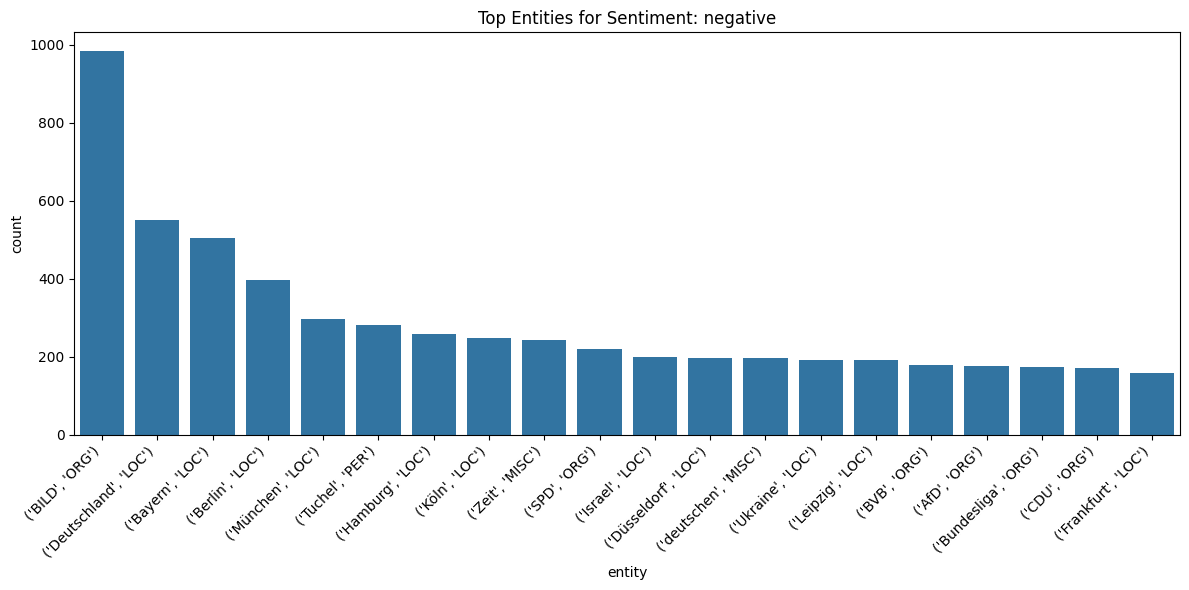

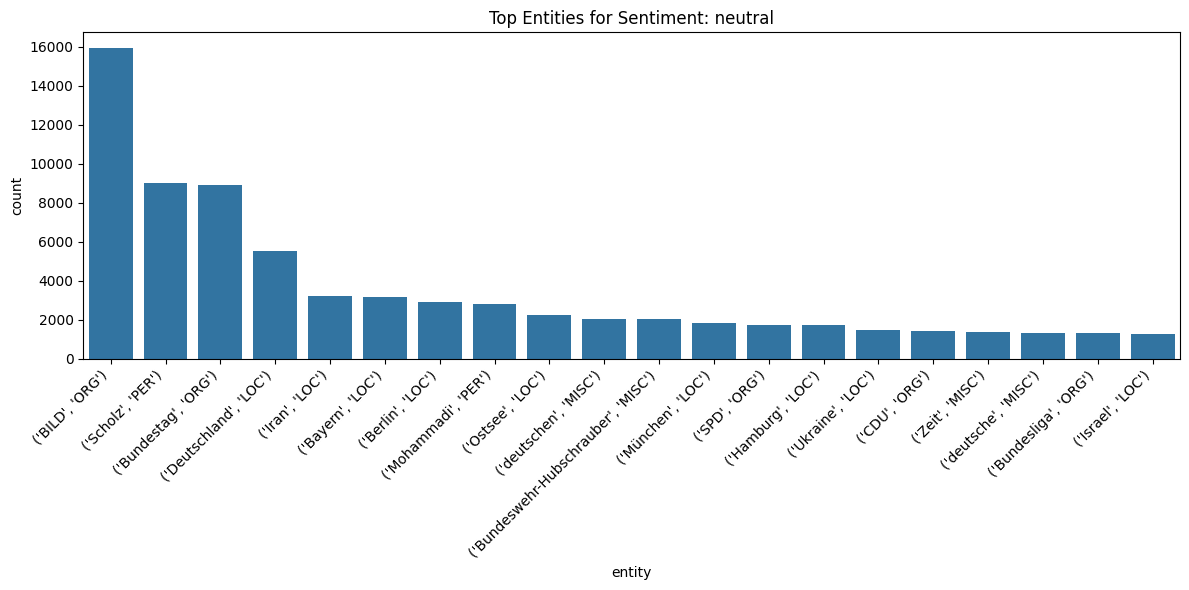

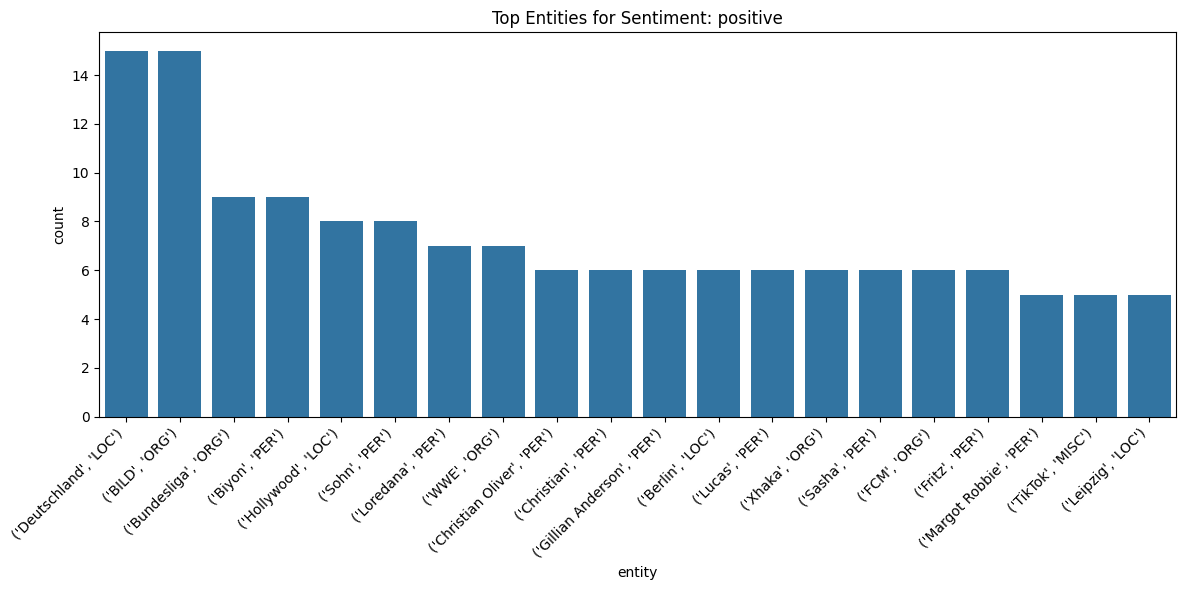

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group the data for visualization
sentiment_entity_counts = top_1000_entities.groupby(['sentiment', 'entity'])['count'].sum().reset_index()

# Create a plot for each sentiment value
for sentiment in sentiment_entity_counts['sentiment'].unique():
    # Filter data for the current sentiment
    sentiment_data = sentiment_entity_counts[sentiment_entity_counts['sentiment'] == sentiment]

    # Sort the entities by count
    sentiment_data = sentiment_data.sort_values('count', ascending=False).head(20) # Limit to top 20 for clarity

    plt.figure(figsize=(12, 6))  # Adjust figure size for better visualization

    # Convert 'entity' column to string type before plotting
    sentiment_data['entity'] = sentiment_data['entity'].astype(str)

    sns.barplot(x='entity', y='count', data=sentiment_data)
    plt.title(f'Top Entities for Sentiment: {sentiment}')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
    plt.tight_layout() # Adjust layout to prevent labels from overlapping

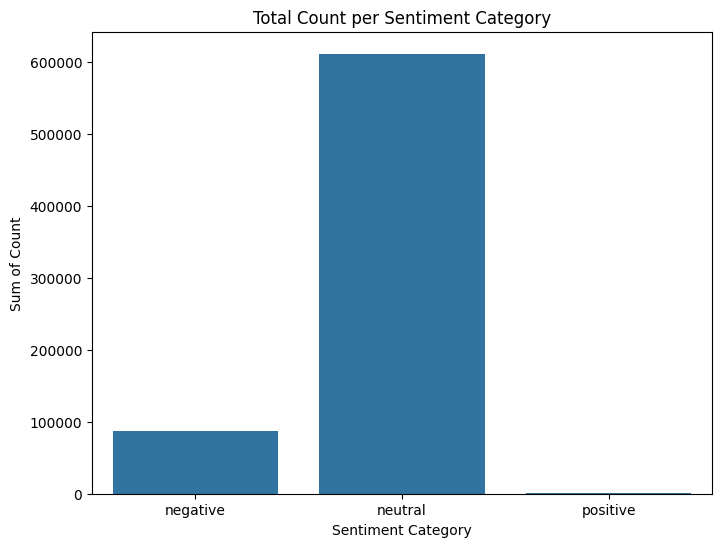

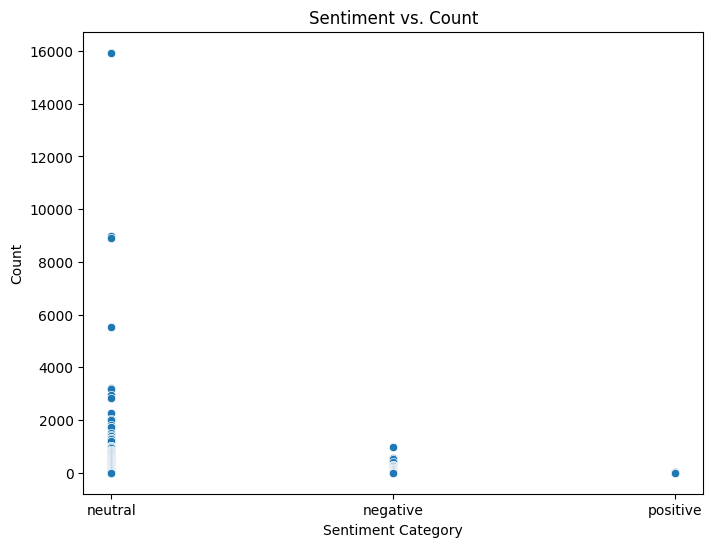

In [ ]:
sentiment_counts = entity_sentiment_mapping.groupby('sentiment')['count'].sum().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='sentiment', y='count', data=sentiment_counts)
plt.title('Total Count per Sentiment Category')
plt.xlabel('Sentiment Category')
plt.ylabel('Sum of Count')
plt.show()

# Scatter plot (if you want to visualize individual entity counts)
plt.figure(figsize=(8, 6))
sns.scatterplot(x='sentiment', y='count', data=entity_sentiment_mapping)
plt.title('Sentiment vs. Count')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.show()

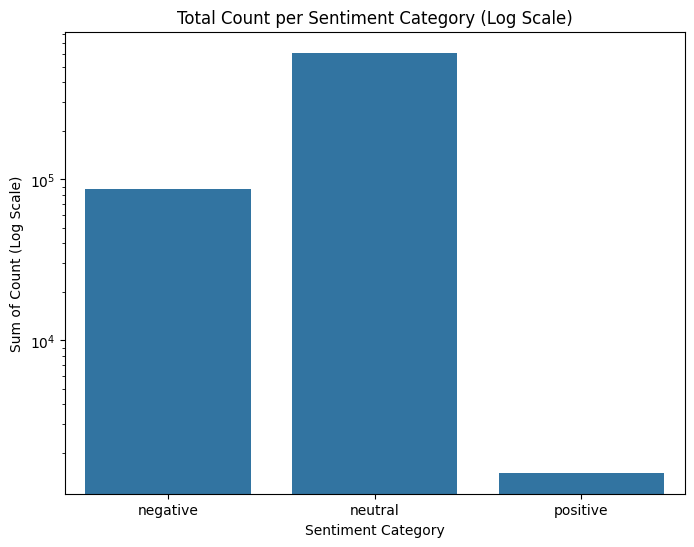

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x='sentiment', y='count', data=sentiment_counts)
plt.yscale('log')  # Use log scale for the y-axis
plt.title('Total Count per Sentiment Category (Log Scale)')
plt.xlabel('Sentiment Category')
plt.ylabel('Sum of Count (Log Scale)')
plt.show()

In [ ]:
# Group by entity and then unstack for stacked bar plot
entity_sentiment_counts = new_df.groupby(['entity', 'sentiment'])['count'].sum().unstack()

# Filter for entities with a large number of mentions (e.g., top 10)
top_entities = entity_sentiment_counts.sum(axis=1).nlargest(10).index
filtered_entity_sentiment_counts = entity_sentiment_counts.loc[top_entities]

# Create the stacked bar plot
filtered_entity_sentiment_counts.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Sentiment Distribution for Top Entities')
plt.xlabel('Entity')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

NameError: name 'new_df' is not defined

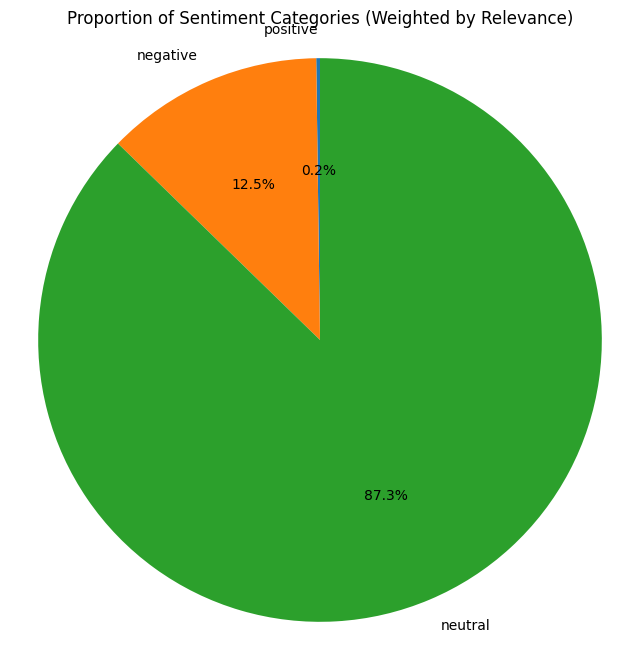

In [ ]:
import matplotlib.pyplot as plt


sentiment_counts = pd.DataFrame({
    'sentiment': ['positive', 'negative', 'neutral'],
    'count': [1502, 87606, 611275]
})

plt.figure(figsize=(8, 8))  # Adjust figure size as needed
plt.pie(sentiment_counts['count'], labels=sentiment_counts['sentiment'], autopct='%1.1f%%', startangle=90)
plt.title('Proportion of Sentiment Categories (Weighted by Relevance)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

## Topic Extraction

In [ ]:
from joblib import Parallel, delayed

In [ ]:
# Funktion zur Extraktion von Nomen und Named Entities
def extract_key_terms(text):
    doc = nlp(text)
    nouns = [token.text.lower() for token in doc if token.pos_ == "NOUN"]
    entities = [ent.text.lower() for ent in doc.ents]
    return list(set(nouns + entities))  # Duplikate entfernen

# Funktion zur Themenfindung basierend auf TF-IDF
def get_topic_from_tfidf(documents):
    tfidf = TfidfVectorizer(max_features=1000, stop_words=None)
    X = tfidf.fit_transform(documents)
    feature_names = tfidf.get_feature_names_out()
    topics = []
    for row in X:
        top_indices = row.toarray()[0].argsort()[-5:][::-1]
        topics.append(", ".join([feature_names[i] for i in top_indices]))
    return topics

# Parallelisierte Extraktion von Schlüsselbegriffen
def parallel_extract_key_terms(texts):
    return Parallel(n_jobs=-1)(delayed(extract_key_terms)(text) for text in texts)



# Erstellen einer Kopie des Datasets
data_topics = data
df_topics = data_topics.copy()

# Sicherstellen, dass maintext kopierbar ist
df_topics.loc[:, "maintext"] = df_topics["maintext"].astype(str).copy()  # Kopieren, um sicherzustellen, dass die Daten beschreibbar sind

# Schlüsselbegriffe extrahieren ohne Parallelisierung
texts = df_topics["maintext"].tolist()  # Umwandlung in Liste
df_topics["key_terms"] = [extract_key_terms(text) for text in texts]  # Sequentiales Verarbeiten (ohne Parallelisierung)

# Key Terms zusammenführen
df_topics["key_terms_joined"] = df_topics["key_terms"].apply(lambda x: " ".join(x))

# TF-IDF-Themen erstellen
df_topics["topic"] = get_topic_from_tfidf(df_topics["key_terms_joined"])


In [ ]:
df_topics.head()

## NER Network Analysis Section

### What's going on here
These 3 functions are the foundations of the NER network analysis. Here's a brief explaination:
#### Extract_entities
This function is called once on all the dataframe, and it's used to extract all of the entities present in the newpaper articles. It returns a list of entities

#### Extract_entity_pairs
This function combines the entities in list of two entities, actually extracting what will become the edges of the graph

#### Generate_network_graph
The main function that creates a graph of the entities. It functions as follows:

##### First two filters
A first filter is passed if we have an entity to analyze, and it filters the entire dataframe.
Then, a second filter is passed according to the conditions, which is a lambda passed as a parameter. Conditions will be specified in future functions

##### Pair the entities
We pair the entities using the function above extract_entity_pairs. We're left with a list

##### Create a new dataframe out of the list, sort the pairs in alphabetical order, then add a weight to the graph
Which means that the weight of a node will be heavier the more times the relationship is mentioned

##### Visualize the graph
First we create a networkx graph to visualize it, but to have a better experience we include the pyvis library

##### Add degree centrality
To have a better insight of how connected a node is, we included node centrality. The bar plot that's left is sorted from the most named entity

In [ ]:
def extract_entities(text):
    doc = ner(text)
    sent_entities=[]
    entity_labels = ['GPE', 'ORG','PER', 'LOC'] # we want to focus only on these entity types
    for sent in doc.sents:
        sent_entities += [ent.text for ent in sent.ents if ent.label_ in entity_labels]
    return sent_entities


def extract_entity_pairs(sent_entities):
    entity_pairs = list(combinations(sent_entities, 2))
    return entity_pairs


def generate_network_graph(conditions, entity=None):
    filtered_df = df
    if entity is not None:
        filtered_df = df[df['entities'].apply(lambda x: entity in x if isinstance(x, list) else False)]
    gen = filtered_df.loc[df.apply(conditions, axis=1), 'entities']

    entity_pairs = []
    for entities in gen:
        if isinstance(entities, list):  # Make sure we handle lists correctly
            entity_pairs += extract_entity_pairs(entities)


    entity_pairs_df = pd.DataFrame(entity_pairs, columns=["source","target"])
    entity_pairs_df = pd.DataFrame(np.sort(entity_pairs_df.values, axis = 1), columns = entity_pairs_df.columns)
    # Let's add the value column so to add weight
    entity_pairs_df["value"] = 1
    entity_pairs_df = entity_pairs_df.groupby(["source","target"], sort=False, as_index=False).sum()

    # Create a graph from a pandas dataframe
    G = nx.from_pandas_edgelist(entity_pairs_df,
                                source = "source",
                                target = "target",
                                edge_attr = "value",
                                create_using = nx.Graph())

    # Add edges to the graph
    G.add_edges_from(entity_pairs)

    net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white', cdn_resources='remote', select_menu=True)

    node_degree = dict(G.degree)

    #Setting up node size attribute
    nx.set_node_attributes(G, node_degree, 'size')

    net.from_nx(G)
    net.show("mygraph.html")
    net.save_graph("mygraph.html")

    # degree centrality, this will do a research on the topic that's most talked about

    degree_dict = nx.degree_centrality(G)
    degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['centrality'])
    degree_df.sort_values('centrality', ascending= False)[0:9].plot(kind="bar")

### The get_network and get_entity functions
These functions help us retrieve information more easily. Here we specify the conditions used in the generate_network_graph function.
They help us retrieve, from top to bottom:
- A network of entities mentioned by a particular journalist;
- A network of entities mentioned in a span of time
- A network of entities mentioned in a span of time, with another entity filter on top
- A network of entities related to a particular topic

Then the last function doesn't generate a network graph, but creates a plot on how many times an entity was mentioned throughout the weeks


In [ ]:
def get_network_by_author(author):
    conditions = lambda row: author in row['authors']
    generate_network_graph(conditions)

def get_network_by_date(date_from= None, date_to=None ):
    conditions = lambda row: date_from <= row['date_publish'] <= date_to
    generate_network_graph(conditions)

def get_entity_by_date(date_from = None, date_to = None, entity = None):
    conditions = lambda row: date_from <= row['date_publish'] <= date_to
    generate_network_graph(conditions, entity)

def get_network_by_topic(topic):
    conditions = lambda row: topic in row['topic']
    generate_network_graph(conditions)

def get_entity_over_time(entity):
    filtered_df = df[df['entities'].apply(lambda x: entity in x if isinstance(x, list) else False)]

    weekly_counts = filtered_df.groupby(pd.Grouper(key='date_publish', freq='W')).size()

    # Plot the data
    plt.figure(figsize=(10, 6))
    weekly_counts.plot(kind='line', marker='o', label=entity, color='blue')
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))


    # Add labels and title
    plt.title(f"Occurrences of {entity} Over Time", fontsize=16)
    plt.xlabel("Date", fontsize=14)
    plt.ylabel("Count", fontsize=14)
    plt.grid(True)
    plt.legend()

    return filtered_df

As mentioned before, we need to extract once every entity present in the dataframe

In [ ]:
df['entities'] = df['maintext'].apply(extract_entities)

Now, let's say we want to research about Olaf Scholz, how much Bild talked about him and when, and with whom. We can start our analysis by seeing how much he was mentioned over time in a newspaper article

In [ ]:
get_entity_over_time('Scholz')

We notice that the results are pretty much stable at around 10-20 points until we reach a peak from the end of february until mid-march. Now let's do a search on the entities relevant around him, in that span of time

In [ ]:
start = pd.Timestamp(2024, 2,20)
end = pd.Timestamp(2024, 3, 21)
get_entity_by_date(start, end, 'Scholz')

By taking a look at the node degree centrality we can see that the most named entities are, apart from himself(graph nodes can point to themselves) and the newspaper(we will exclude these two from our considerations), are all topic related to politics, of course.

What we get from this is that there might have some events related to these entities that was mentioned a number of times in Bild.
For example, on February 16 2024(when the curve starts to rise), Chancellor Scholz met with Ukrainian President Zelensky in Berlin, and the two leaders signed a bilateral agreement for long-term support for Ukraine.

This is only one example that explains why the newspaper chose to keep talking about him